# Imports

In [1]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional

C:\Users\ericr\Anaconda2\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# Supporting Functions

In [2]:
def print_distribution(df, labels_column_name):
    n = df.shape[0]
    print("{} labels frequency:".format(labels_column_name))
    print("Value\tCount\tPercent")
    indeces = df[labels_column_name].value_counts().index.tolist()
    counts = df[labels_column_name].value_counts().tolist()
    for val, count in zip(indeces, counts):
        print("{}\t{}\t{}%".format(val, count, (count / float(n)) * 100))
    
def get_max_words(text_arr):
    max_words = 0
    for line in text_arr:
        num_words = len(str(line).split())
        if num_words > max_words:
            max_words = num_words
    return max_words

# Load data

In [3]:
# Load in the csv data
#headlines_df = pd.read_csv("../data/headlines/labeled_headlines.csv", index_col=0, parse_dates=[0])
tweets_df = pd.read_csv('C:\\Users\\ericr\\Google Drive\\schoolwork\\current classes\\CS 230\\Project\\230_crypto\\data\\twitter\\hourly\\labeled_tweets_hourly.csv', encoding='ISO-8859-1')

print("There are {} tweets".format(tweets_df.shape[0]))
tweets_df.head()

There are 14422 tweets


,Timestamp,Text,1_hr_PC,2_hr_PC,6_hr_PC,12_hr_PC,24_hr_PC
0,2017-01-02 00:00,Did anyone notice Bitcoin hit $1000 a few hour...,0.224013,0.65496,1.423434,2.964399,2.537469
1,2017-01-02 00:00,"Bitcoin Price Tops $1,000 in First Day of 2017...",0.224013,0.65496,1.423434,2.964399,2.537469
2,2017-01-02 00:00,The latest Bitcoin Price Index is 997.75 USD h...,0.224013,0.65496,1.423434,2.964399,2.537469
3,2017-01-02 00:00,Bitcoinã3å¹´ã¶ãã®1000ãã«ã«åãã£ã...,0.224013,0.65496,1.423434,2.964399,2.537469
4,2017-01-02 00:00,#Bitcoin predictions from #WebBot @clif_high h...,0.224013,0.65496,1.423434,2.964399,2.537469


In [4]:
train_size = 11538 #use 80% of data for training

train_df = tweets_df[:train_size].copy()
test_df = tweets_df[train_size:].copy()

# Data setup

Max number of words in a post: 82


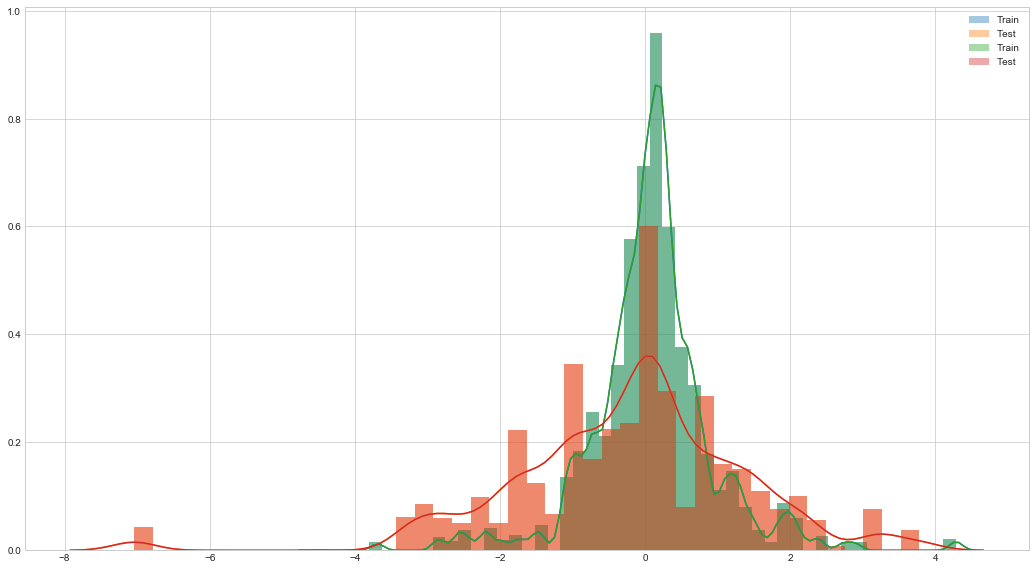

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)

# Label and title columns in datasets
BTC_LABEL_COL = '1_hr_PC'
TEXT_COL = 'Text'

# Determine max post length
max_words_train = get_max_words(train_df[TEXT_COL].values)
max_words_test = get_max_words(test_df[TEXT_COL].values)
max_words = max(max_words_train, max_words_test)
print("Max number of words in a post: {}".format(max_words))

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(train_df[BTC_LABEL_COL].values, label='Train')
sns.distplot(test_df[BTC_LABEL_COL].values, label='Test')
plt.legend()
plt.show()

In [8]:
# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_btc) = train_df[TEXT_COL].values, train_df[BTC_LABEL_COL]
(x_test, y_test_btc) = test_df[TEXT_COL].values, test_df[BTC_LABEL_COL]

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")


Getting x_train, y_train, x_test, and y_test...
11538 train sequences
2884 test sequences
----------------------------


# Model setup (part 1/3)

In [9]:
test1 = np.asarray([str(x) for x in x_train])
test2 = np.asarray([str(x) for x in x_test])

# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
epochs = 10 

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(test1)

# Vectorize each headline
train_sequences = tokenizer.texts_to_sequences(test1)
test_sequences = tokenizer.texts_to_sequences(test2)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)  

Pad sequences (samples x time)
x_train shape: (11538, 82)
x_test shape: (2884, 82)


# Model setup (part 2/3)

In [10]:
# Build embedding layer using word2vec
#EMBEDDING_FILE = "C:\\Users\\ericr\\Documents\\GoogleNews-vectors-negative300.bin\\GoogleNews-vectors-negative300.bin"
EMBEDDING_FILE = "C:\\Users\\ericr\\Google Drive\\schoolwork\\current classes\\CS 230\\Project\\230_crypto\\models\\word2vec\\crypto-word2vec-all-200.bin"
#EMBEDDING_DIM = 300
EMBEDDING_DIM = 200
#word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
word2vec = KeyedVectors.load(EMBEDDING_FILE)

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False) 

# Model setup (part 3/3)

In [11]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(1)(X)

# BTC Model

In [12]:
# Define the BTC model
model = Model(inputs=sequence_input, 
                  outputs=X)

# Compile the BTC model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

# Select BTC labels for y
y_train = y_train_btc
y_test = y_test_btc


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 82)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 82, 200)           6616200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 6,953,353
Trainable params: 337,153
Non-trainable params: 6,616,200
_________________________________________________________________


In [13]:
# Run the BTC model
model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(x_test, y_test))

Train on 11538 samples, validate on 2884 samples
Epoch 1/10
11538/11538 [==============================] - 128s 11ms/step - loss: 0.7460 - acc: 0.0000e+00 - val_loss: 2.6892 - val_acc: 0.0000e+00
Epoch 2/10
11538/11538 [==============================] - 121s 11ms/step - loss: 0.7322 - acc: 0.0000e+00 - val_loss: 2.7306 - val_acc: 0.0000e+00
Epoch 3/10
11538/11538 [==============================] - 122s 11ms/step - loss: 0.7232 - acc: 0.0000e+00 - val_loss: 2.6668 - val_acc: 0.0000e+00
Epoch 4/10
11538/11538 [==============================] - 122s 11ms/step - loss: 0.7143 - acc: 0.0000e+00 - val_loss: 2.6731 - val_acc: 0.0000e+00
Epoch 5/10
11538/11538 [==============================] - 122s 11ms/step - loss: 0.7010 - acc: 0.0000e+00 - val_loss: 2.7406 - val_acc: 0.0000e+00
Epoch 6/10
11538/11538 [==============================] - 124s 11ms/step - loss: 0.6748 - acc: 0.0000e+00 - val_loss: 2.6945 - val_acc: 0.0000e+00
Epoch 7/10
11538/11538 [==============================] - 123s 11ms/s

In [14]:
score, acc = model.evaluate(x_test, 
                            y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

2884/2884 [==============================] - 9s 3ms/step
Test score: 2.83597115695
Test accuracy: 0.0


# Evaluate the results
    - Look at the distribution of the predicted results to see if the model makes large predictions
    - Perform some error analysis

In [15]:
predictions = model.predict(x_test)

In [16]:
pred_series = pd.Series(np.squeeze(predictions))
pred_series.describe()

count    2884.000000
mean        0.088693
std         0.472914
min        -2.017282
25%        -0.130720
50%         0.093396
75%         0.313758
max         3.439549
dtype: float64

### First, print out text with corresponding percent changes greater than the cutoff

In [17]:
##### Set cutoff
cutoff = 2.0

test_text = list(test_df[TEXT_COL].values)
preds_list = list(np.squeeze(predictions))
labels_list = list(y_test)
count = 0

for i, label in enumerate(labels_list):
    if abs(label) >= cutoff:
        print('------------------')
        print('Text:\n {}'.format(test_text[i]))
        print('\tActual:  {}'.format(labels_list[i]))
        count += 1
        
print("----------------------")
print("Count of examples greater than cutoff: {}".format(count))

------------------
Text:
 Still kicking myself for not buying #bitcoin at $200. Which is why I'm doing my happy dance after buying #litecoin this week under $100. #BTC #LTC
	Actual:  -2.700979629
------------------
Text:
 Bitcoin is going crash hella hard in 2018 calling it now
	Actual:  -2.700979629
------------------
Text:
 With bitcoin futures set to trade, here's how it's going to work http:// a.msn.com/00/en-us/BBGpe cr?ocid=st â¦
	Actual:  -2.700979629
------------------
Text:
 Cramer Remix: Bitcoin is the least transparent bubble Iâve ever seen http:// cnb.cx/2BXQBRI
	Actual:  -2.700979629
------------------
Text:
 If Lil Pump bought Bit Coin instead of a new chain. Those 3 racks would be worth 9 racks right now.
	Actual:  -2.700979629
------------------
Text:
 bitcoin mining is going to hit its cap in like 2 years and i don't know enough about economics to tell if that means it'll crash or skyrocket
	Actual:  -2.700979629
------------------
Text:
 Cramer Remix: Bitcoin is th

### Now print out the text corresponding to predictions greater than the cutoff

In [18]:
count = 0

for i, pred in enumerate(preds_list):
    if abs(pred) >= cutoff:
        print('------------------')
        print('Text:\n {}'.format(test_text[i]))
        print('\tPrediction: {}'.format(pred))
        print('\tActual:  {}'.format(labels_list[i]))
        count += 1

print("----------------------")
print("Count of examples greater than cutoff: {}".format(count))

------------------
Text:
 #RT @DecentralizedTV : OMG! Itâs Bitcoin Arbitrage! Futures and Exchanges! http:// youtube.com/watch?v=ynl4nI zZuiI&feature=youtu.be â¦ https:// decentralized.tv/btc-arbitrage- futures/ â¦
	Prediction: -2.017282009124756
	Actual:  0.087557604
------------------
Text:
 Twit: @Bit_Real #ICO , is a #Blockchain based #Decentralized platform for AR VR 3D #Gaming . Sharing, Exchange, Viewing, Creating, & Gaming of #VR #3D #AR Content. #Tokensale #Airdrop #Bounty for #Freecoin #Bitcoin #cryptocurrency #ETHEREUM #ERC20 https:// docs.google.com/forms/d/e/1FAI pQLSfXVBkzl_czfzSlFK1Nh8z6qYbygzYpTi60yrls3GawlNoQEA/viewform â¦
	Prediction: 3.402405023574829
	Actual:  -1.775456266
------------------
Text:
 XBS Airdrop Phase 1 is now live #bitcoin #xbs #btc #airdrop @airdrop_free @hamza_znad @bousnate @byzran @BTCX_Official @BitcoinNitro https:// docs.google.com/forms/d/e/1FAI pQLScONYqAAO5L6cLBt6lK_1B5Vr56wh5Mkot7NOOmmaZsH1B9cw/viewform â¦
	Prediction: 3.2134990692138